In [1]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import numpy as np
import cv2
import shutil

import torch
from torch import nn, optim
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.utils import make_grid
import torchvision.transforms as T

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Indoor Plant Varieties for Computer Vision Applications: A Diverse Image Dataset
https://data.mendeley.com/datasets/ct79299k27/1#:~:text=dataset%20consists%20of%201172%20high,This


### Information about dataset from source:


Published: 4 November 2024
|
Version 1
|
DOI:
10.17632/ct79299k27.1
Contributors:
Sajib Bin Mamun
,
Md Asraful Sharker Nirob
,
Dr. Md Taimur Ahad
,
Mashreka Akter
,
Pranta Saha
,
Md Assaduzzaman
Description
The Indoor Plant Varieties Dataset is a valuable asset for researchers, plant care specialists, and AI developers, offering essential tools for the accurate identification and classification of common indoor plant species. This dataset supports the development of computer vision models tailored to indoor plant recognition, enabling users to create applications that simplify plant identification and care.

Collected between October 28 and November 20, 2023, the dataset consists of 1172 high-resolution images (3000x3000 pixels, JPG format) across seven plant classes: Aglaonema, Cryptanthus, Devil’s Ivy, Heartleaf Philodendron, N-Joy Pothos, Rhaphidophora, and ZZ Plant. Each class represents unique indoor plant species frequently found in homes and offices, collected from BADC (Bangladesh Agricultural Development Corporation) in Kashimpur and nearby nurseries. Images were captured using a Xiaomi M2101K61 smartphone, ensuring consistency in quality. Domain experts (agronomists from BADC) confirmed the class labels, adding reliability to the dataset. To enhance the dataset further, Data Augmentation techniques were applied, including flipping, rotation, zoom, shear, brightness adjustments, and noise reduction. This augmentation expanded the dataset to 7000 images (1000 per class), enhancing the effectiveness of deep learning models for accurate plant classification.


In [3]:
!wget -O IndoorPlantVarieties.zip "https://data.mendeley.com/public-files/datasets/ct79299k27/files/bb6460a2-ebdc-45b3-8a7d-5296d73fc1ea/file_downloaded"


--2025-05-16 18:30:22--  https://data.mendeley.com/public-files/datasets/ct79299k27/files/bb6460a2-ebdc-45b3-8a7d-5296d73fc1ea/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/47314b66-a9e9-4cf2-aeef-4f73358b1904 [following]
--2025-05-16 18:30:23--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/47314b66-a9e9-4cf2-aeef-4f73358b1904
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.118.90, 3.5.65.102, 3.5.68.164, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.118.90|:443..

In [4]:
!unzip IndoorPlantVarieties.zip -d IndoorPlantVarieties

Streaming output truncated to the last 5000 lines.
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102757_aug508.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102757_aug510.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102757_aug539.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102757_aug747.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102808.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102808_aug346.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102808_aug48.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102822.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102822_aug44.jpg  
  inflating: IndoorPlantVarieties/Augmented Data/Devil_s Ivy/IMG_20231029_102822_aug616.jpg  
  inflating: IndoorPlantV

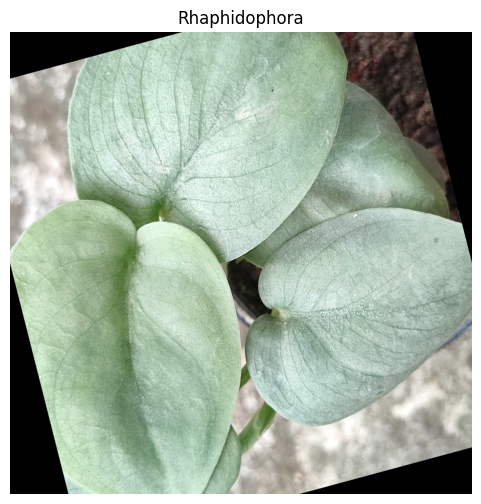

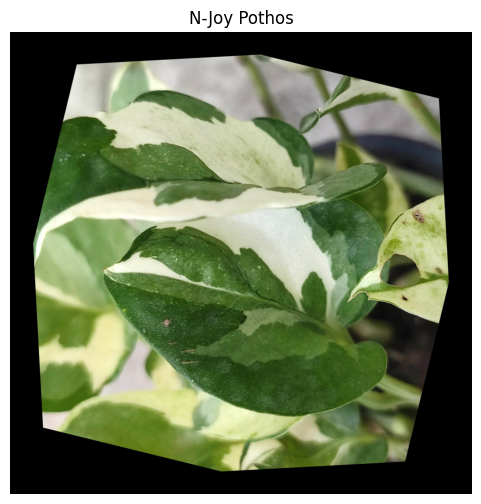

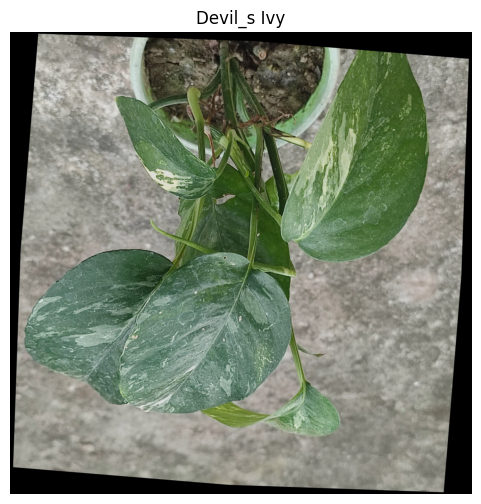

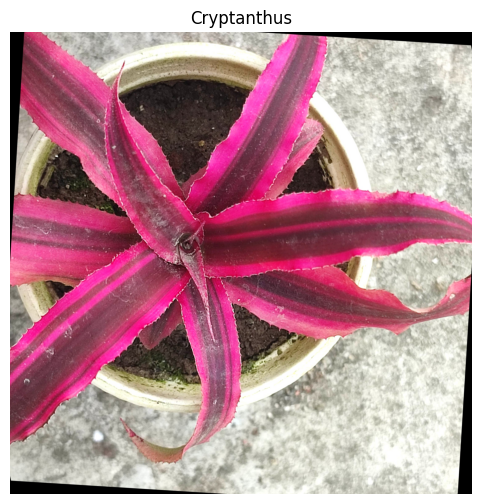

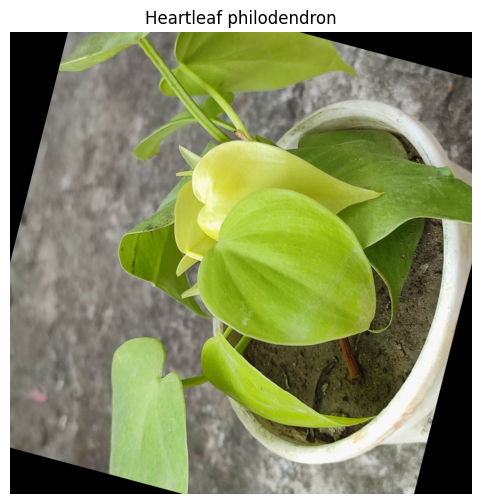

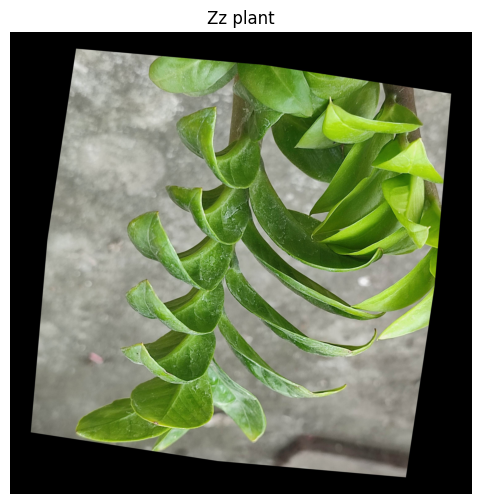

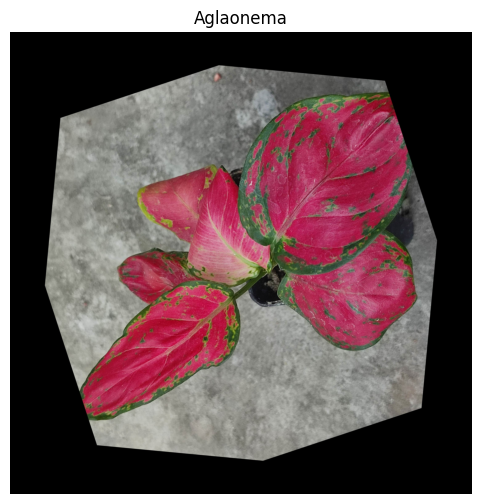

[1000, 1000, 1000, 1000, 1000, 1000, 1000]


7000

In [5]:
counts = []

for folder, _, files in os.walk('/content/IndoorPlantVarieties/Augmented Data'):
    if files:
      counts.append(len(files))
      random_ = random.choice(files)
      image_path = os.path.join(folder, random_)

      # Open and display the image
      img = Image.open(image_path)
      plt.figure(figsize=(6,6))
      plt.title(os.path.basename(folder))
      plt.imshow(img)
      plt.axis('off')
      plt.show()

print(counts)
sum(counts)

The images are already augmented. The lighting is much more consistent in this dataset.

# Creating support model

In [6]:
batch_size = 32

In [7]:
transforms = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [8]:
data_dir = '/content/IndoorPlantVarieties/Augmented Data'

In [9]:
full_data = datasets.ImageFolder(root=data_dir)
classes = full_data.classes

In [10]:
labels2 = [s[1] for s in full_data.samples] # will use numbers for my labels and convert back to class after

In [11]:
# 1 train/val set, 20 % of images in val
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_ids, val_ids = next(strat.split(full_data.samples, labels2))

In [12]:
#creating my datasets and putting them through the transforms
train_d = Subset(datasets.ImageFolder(root=data_dir, transform=transforms),train_ids)
val_d = Subset(datasets.ImageFolder(root=data_dir, transform=transforms),val_ids)

print(len(train_d))
print(len(val_d))

5600
1400


In [13]:
# load data
# randomly shuffle at start of the epoch
# can only use 2 workers in google colab
# pin true, as using gpu
train_loader = DataLoader(train_d, batch_size=batch_size,shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_d, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

In [14]:
device = torch.device('cuda') # using google colabs gpu

In [15]:
model = models.resnet50(pretrained=True)

# this time I will have two classes in last class head
# but adding this so it is possible to merge in the weights
# of my previous model
model.fc = nn.Linear(model.fc.in_features, 47)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [16]:
class_model_finetuned = torch.load("/content/drive/MyDrive/final cv harvard/final_aug_twolayer_planttype.pth", map_location=device)


In [17]:
# I am replacing the weights with the weight I
# got after finetuning on plant classes
model.load_state_dict(class_model_finetuned)

<All keys matched successfully>

In [18]:
# setting up the two-class head
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

In [19]:
# Freezing it all, also the layer we
# finetuned earlier.
# lets try just classification now
for param in model.parameters():
    param.requires_grad = False

In [20]:
# keeping same loss
criterion = nn.CrossEntropyLoss()



In [21]:
# unfreezing just last layer
for param in model.fc.parameters():
    param.requires_grad = True

In [22]:
optimizer = optim.Adam(model.fc.parameters(), lr = 1e-3)

In [23]:
# move model to cuda
model = model.to(device)

# Training

In [24]:
# same chatgpt code as model1

for epoch in range(5):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_d)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, preds = torch.max(model(inputs), 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{5} - Train Loss: {train_loss} - Val Acc: {val_acc}")



Epoch 1/5 - Train Loss: 0.20828041269310882 - Val Acc: 0.9957142857142857
Epoch 2/5 - Train Loss: 0.03230338473139065 - Val Acc: 0.9971428571428571
Epoch 3/5 - Train Loss: 0.02011682170709329 - Val Acc: 0.9978571428571429
Epoch 4/5 - Train Loss: 0.01581714413993593 - Val Acc: 0.9978571428571429
Epoch 5/5 - Train Loss: 0.010876851167662868 - Val Acc: 0.9992857142857143


In [26]:
lr = 1e-4

for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [27]:
# same chatgpt code as model1

for epoch in range(5):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_d)

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            _, preds = torch.max(model(inputs), 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{5} - Train Loss: {train_loss} - Val Acc: {val_acc}")



Epoch 1/5 - Train Loss: 0.006891147797993783 - Val Acc: 0.9992857142857143
Epoch 2/5 - Train Loss: 0.00869973119880472 - Val Acc: 0.9992857142857143


KeyboardInterrupt: 

In [28]:
head_path = '/content/drive/MyDrive/final cv harvardfirst_support_model.pth'
torch.save(model.state_dict(), head_path)
print("saved")

saved
